<a href="https://colab.research.google.com/github/sensei-jirving/Online-DS-PT-01.24.22-cohort-notes/blob/main/Week_08/Lecture_02/CodeAlong/Churn_Boosting_CodeAlong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boosting Live Class CodeAlong Sample Solutions

## Classification: Data at: [Churn Modeling](https://drive.google.com/file/d/1_6ct38p8qzXSNmgrX4UGcbzhjqA74Ht4/view?usp=sharing)

Task: predict which customers will churn (`Exited` column)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define a function that takes in arguments and prints out a classification report, confusion matrix and ROC AUC
def evaluate_classification(model, X_test, y_test, cmap=None,
                            normalize='true', classes=None, figsize=(20,5)):
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, target_names=classes))

  fig, ax = plt.subplots(ncols=3, figsize=figsize)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Greens',
                                        display_labels=classes,
                                        ax=ax[0])
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
                                        display_labels=classes, normalize='true',
                                        ax=ax[1])
  
  curve = metrics.plot_roc_curve(model, X_test, y_test, ax=ax[2])
  curve.ax_.grid()
  curve.ax_.plot([0, 1], [0, 1], ls=':')

## Load and examine data

In [ ]:
path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS71sJ-vej4Tegrs6PefHyIvROPUMMvzlM2cBFtO2-VfBbu4UzCcjr7H7Mn7MxB7UFQT7BvTfZ19ByS/pub?output=csv'
churn_df = pd.read_csv(path)
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


The RowNumber, CustomerId, and Surname are irrelevant to churn and are highly specific to each customer.  We will drop them.

In [ ]:
churn_df = churn_df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [ ]:
churn_df.duplicated().sum()

0

Examine the distributions of and correlations between columns (distributions are on the diagonal)

In [ ]:
churn_df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


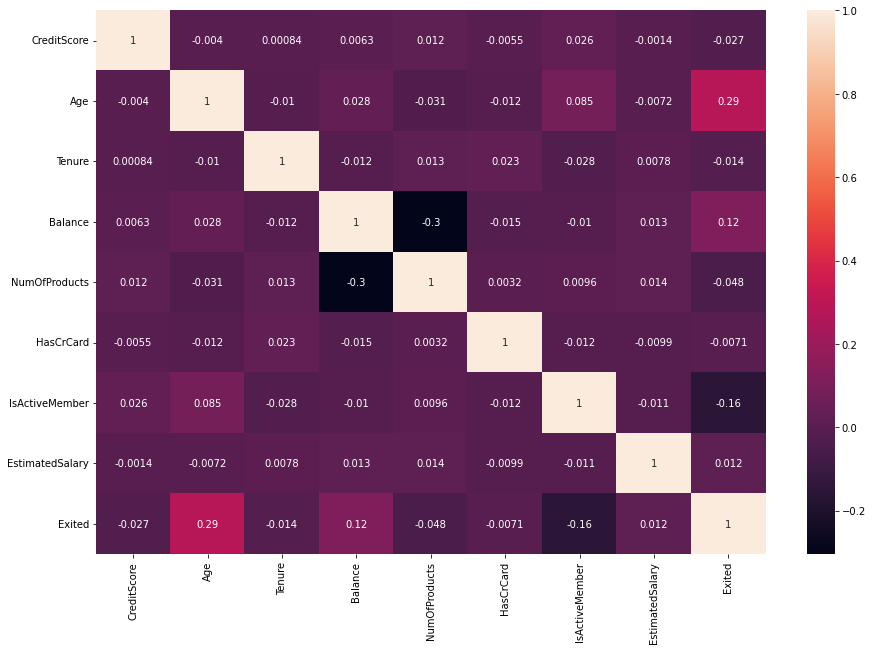

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(churn_df.corr(), annot=True, ax=ax)

# Class Balance



In [ ]:
churn_df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [ ]:
X = churn_df.drop(columns='Exited')

y = churn_df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Preprocessing Pipeline

A ColumnTransformer allows you to apply different preprocessing steps to different columns.  In this case we want to one-hot encode the categorical columns and scale the numeric columns.

A ColumnSelector returns certain columns based on their data type.  ColumnTransformer can also just take a list of column names instead if desired.

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()

cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

column_transformer = make_column_transformer((ohe, cat_selector), (scaler, num_selector))

# Adaboost

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1991
           1       0.73      0.50      0.59       509

    accuracy                           0.86      2500
   macro avg       0.81      0.72      0.75      2500
weighted avg       0.85      0.86      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


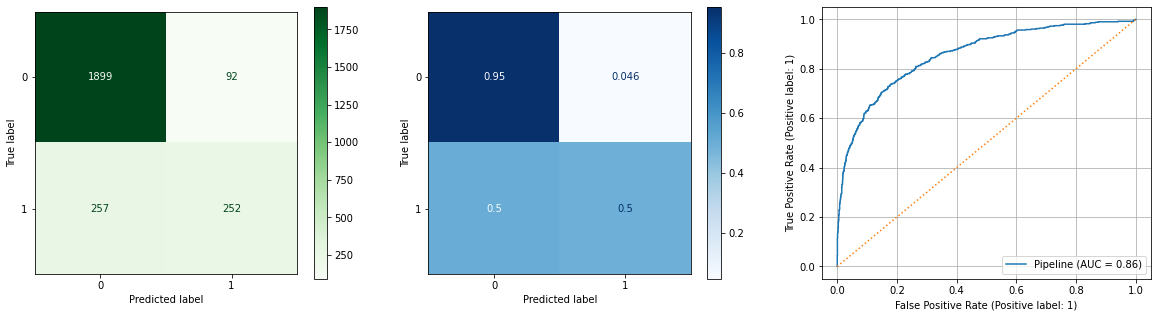

In [ ]:
ada_pipe = make_pipeline(column_transformer, AdaBoostClassifier())

ada_pipe.fit(X_train, y_train)

evaluate_classification(ada_pipe, X_test, y_test)

# Light GBM

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1991
           1       0.75      0.50      0.60       509

    accuracy                           0.86      2500
   macro avg       0.81      0.73      0.76      2500
weighted avg       0.85      0.86      0.85      2500



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


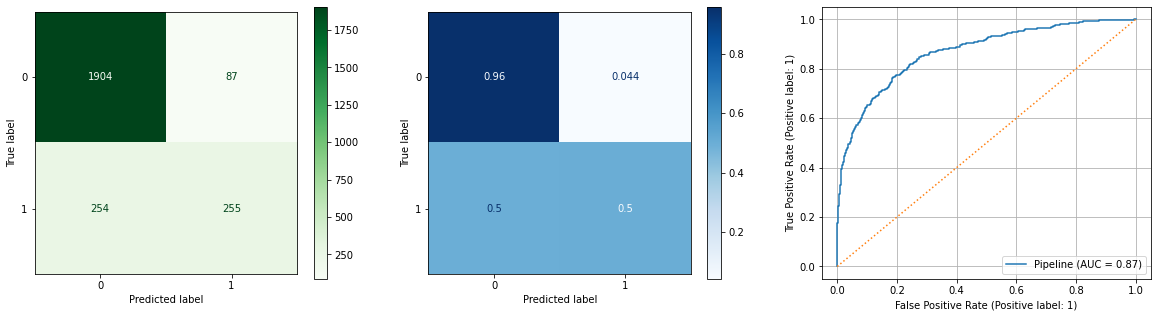

In [ ]:
lgb_pipe = make_pipeline(column_transformer, LGBMClassifier())

lgb_pipe.fit(X_train, y_train)

evaluate_classification(lgb_pipe, X_test, y_test)

# XGBoost

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1991
           1       0.81      0.49      0.61       509

    accuracy                           0.87      2500
   macro avg       0.85      0.73      0.77      2500
weighted avg       0.87      0.87      0.86      2500



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


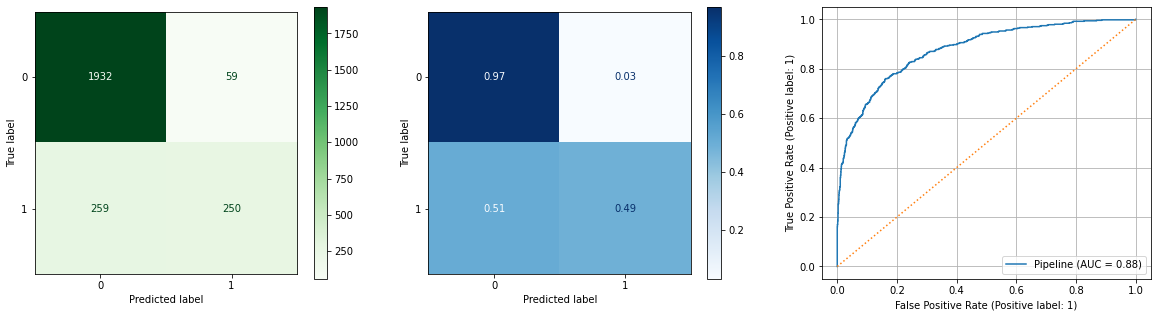

In [ ]:
xgb_pipe = make_pipeline(column_transformer, XGBClassifier())

xgb_pipe.fit(X_train, y_train)

evaluate_classification(xgb_pipe, X_test, y_test)

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1991
           1       0.40      0.72      0.51       509

    accuracy                           0.72      2500
   macro avg       0.65      0.72      0.66      2500
weighted avg       0.81      0.72      0.74      2500



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


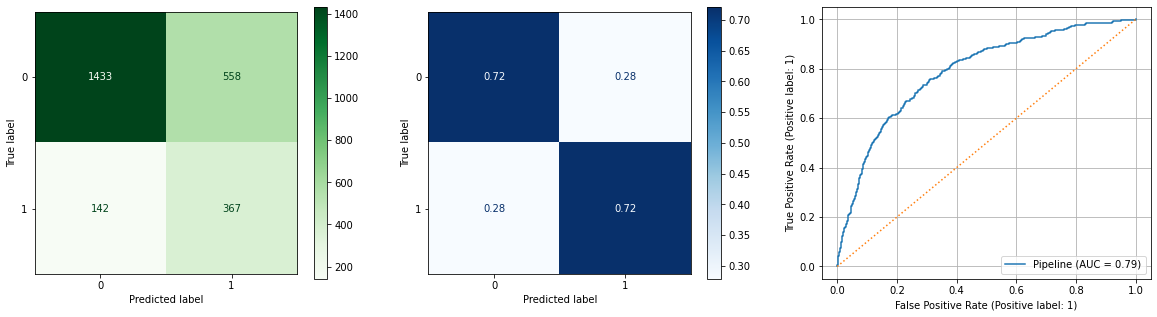

In [ ]:
log_reg = make_pipeline(column_transformer, LogisticRegression(class_weight='balanced'))

log_reg.fit(X_train, y_train)

evaluate_classification(log_reg, X_test, y_test)